In [1]:
from pyomo.environ import (Constraint,
                           Var,
                           ConcreteModel,
                           Expression,
                           Param,
                           Objective,
                           SolverFactory,
                           TransformationFactory,
                           value)

from pyomo.network import Arc, SequentialDecomposition

from idaes.core.util.initialization import propagate_state

# Import plotting functions
import matplotlib.pyplot as plt

# Import numpy library 
import numpy as np

import pandas as pd

# Import the main FlowsheetBlock from IDAES. The flowsheet block will contain the unit model
from idaes.core import FlowsheetBlock

import idaes.logger as idaeslog
from pyomo.opt import TerminationCondition, SolverStatus

# Import the degrees_of_freedom function from the idaes.core.util.model_statistics package
# DOF = Number of Model Variables - Number of Model Constraints
from idaes.core.util.model_statistics import degrees_of_freedom

# Import the Generic Parameter Block
from idaes.generic_models.properties.core.generic.generic_property import (
        GenericParameterBlock)

# Import unit models from the model library
from idaes.generic_models.unit_models import Flash

In [2]:
from HFC32_hmimFAP_PR import configuration
data = pd.read_csv('R32_hmimFAP.csv')

solver = SolverFactory('ipopt')
solver.options = {'tol': 1e-6}

In [3]:
m = ConcreteModel()

m.fs = FlowsheetBlock(default={"dynamic": False})

m.fs.properties = GenericParameterBlock(default=configuration)

m.fs.F101 = Flash(default={"property_package": m.fs.properties,
                           "has_heat_transfer": True,
                           "has_pressure_change": True})

m.fs.F101.inlet.flow_mol.fix(1)
m.fs.F101.inlet.temperature.fix(323.15)
m.fs.F101.inlet.pressure.fix(399800)
m.fs.F101.inlet.mole_frac_comp[0,'R32'].fix(0.5)

m.fs.properties.PR_kappa_A['hmimFAP', 'R32'].fix(-0.1983)
m.fs.properties.PR_kappa_A['R32', 'hmimFAP'].fix(-0.0779)
m.fs.properties.PR_kappa_B['hmimFAP', 'R32'].fix(0.0)
m.fs.properties.PR_kappa_B['R32', 'hmimFAP'].fix(0.0)

# Initialize the flash unit
m.fs.F101.initialize(outlvl=idaeslog.CRITICAL)

# Fix the state variables on the state block
# m.fs.F101.inlet.pressure.unfix()
m.fs.F101.inlet.mole_frac_comp[0,'hmimFAP'].unfix()

R32_x = np.zeros((len(data)))
P = np.zeros((len(data)))



In [4]:
bmim = np.linspace(data["x_hmimFAP"].iloc[6], data["x_hmimFAP"].iloc[0], 15)

P = np.zeros((len(bmim)))
P0 = np.zeros((len(bmim)))
R32_x1 = np.zeros((len(bmim)))
m.fs.liq = Param(mutable=True,default=0.040)
m.fs.liquid = Constraint(expr=m.fs.F101.liq_outlet.mole_frac_comp[0, "hmimFAP"] == m.fs.liq)

for i in range(len(bmim)-1):
    print(i)
    m.fs.liq = bmim[i]
    a = bmim[i]
    b = 1-(bmim[i])

    P0[i] = 1296495.61*b**2 + 411077.67*b + 24234.30
    print(P0[i])

    m.fs.F101.inlet.temperature.fix(298.001)
    m.fs.F101.inlet.pressure.fix(P0[i])
    m.fs.F101.inlet.mole_frac_comp[0,'R32'].fix(1-(bmim[i]-0.1))
    m.fs.F101.inlet.mole_frac_comp[0,'hmimFAP'].fix(bmim[i]-0.1)
    m.fs.F101.vap_outlet.temperature.fix(298.001)
    m.fs.F101.vap_outlet.pressure.fix(P0[i])
    m.fs.F101.vap_outlet.pressure.unfix()
    
    m.fs.F101.initialize(outlvl=idaeslog.CRITICAL)
    
    try:
        m.fs.F101.initialize(outlvl=idaeslog.CRITICAL)

        status = solver.solve(m, tee = False)

        if (status.solver.status == SolverStatus.ok) and (status.solver.termination_condition == TerminationCondition.optimal):

            R32_x1[i] = value(m.fs.F101.liq_outlet.mole_frac_comp[0,'R32']) 
            P[i] = value(m.fs.F101.vap_outlet.pressure[0])

        else:
            print('Infeasible.')
            
    except ValueError:
        
            R32_x1[i] = "NaN"
            P[i] = "NaN"


0
992313.546624
1
888880.2548356922
2
791088.160971512
3
698937.2650314593
4
612427.5670155338
5
531559.066923736
6
456331.76475606556
7
386745.6605125224
8
322800.7541931068
9
264497.04579781875
10
211834.53532665814
11
164813.22277962486
12
123433.10815671916
13
87694.19145794079


In [5]:
print(P)
# print(data["pressure"])
# print(R125_x)
# print(data["x_R125"])

[1002310.34813004  879863.72754513  772991.38795758  678903.3535352
  595240.97292744  520098.21823077  451958.96279555  389621.02267623
  332128.47051614  278716.84841385  228770.47999145  181789.72309482
  137365.94911765   95162.40469267       0.        ]


In [6]:
m.fs.F101.report()


Unit : fs.F101                                                             Time: 0.0
------------------------------------------------------------------------------------
    Unit Performance

    Variables: 

    Key             : Value   : Fixed : Bounds
          Heat Duty : -191.71 : False : (None, None)
    Pressure Change :  7468.2 : False : (None, None)

------------------------------------------------------------------------------------
    Stream Table
                             Inlet  Vapor Outlet  Liquid Outlet
    flow_mol                1.0000      0.11282     0.88718    
    mole_frac_comp hmimFAP 0.78636   1.0000e-08     0.88636    
    mole_frac_comp R32     0.21364       1.0000     0.11364    
    temperature             298.00       298.00      298.00    
    pressure                87694.       95162.      95162.    


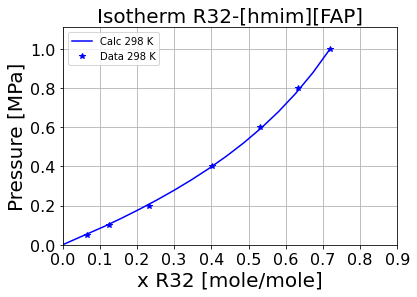

In [7]:
# for i in range(len(P)):
#     P[i] = P[i]*1e6
P1= np.zeros((len(P)))

for i in range(len(P)):
    P1[i] = P[i]/1e6

plt.plot(R32_x1,P1,"b",label="Calc 298 K")  
plt.plot(data["x_R32"][0:7],data["pressure"][0:7]/1e6,"*",color='b',label="Data 298 K")  
plt.title('Isotherm R32-[hmim][FAP]',fontsize=20)
plt.ylabel('Pressure [MPa]',fontsize=20)
plt.xlabel('x R32 [mole/mole]',fontsize=20)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.grid(True)
plt.ylim(0,1.110000)
plt.xlim(0,0.9)
plt.legend(fontsize=10)
# plt.savefig('Isotherm R32-[bmim][PF6]_bin.png', bbox_inches='tight',dpi=300)
plt.show()

In [8]:
df = pd.DataFrame(P)
# df.to_csv('P_cons_32.csv')
# df.to_csv('P_lin_32.csv')
# df.to_csv('P_ter_32.csv')
# df.to_csv('P_x_32.csv')